<a href="https://colab.research.google.com/github/nitaifingerhut/cs236608/blob/master/introduction_to_RecLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reclab installation. This may take a minute or two
!pip install pybind11
!pip install reclab[recommenders]
!cp /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.cpython-36m-x86_64-linux-gnu.so /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.so
!git clone https://github.com/berkeley-reclab/RecLab /usr/local/lib/python3.7/dist-packages/reclab2
!cp -a /usr/local/lib/python3.7/dist-packages/reclab2/reclab/recommenders/. /usr/local/lib/python3.7/dist-packages/reclab/recommenders/

# Introduction to RecLab
In our next workshop we will be using *RecLab* - a simulation framework for evaluating different recommendation algorithms ([Reclab's website](https://berkeley-reclab.github.io/), [arxiv](https://arxiv.org/pdf/2011.07931.pdf)).

The framework consists of 2 main components - Environments and Recommenders.

**Environment:**

An *Environment* defines the population of users and the collection of available items. It specifies the users' behavior, their preferences and the way they change over time, how the users rate items, etc.

**Recommender:**

A *Recommender* generates item recommendations to users based on past ratings.

You can create environments and recommenders of your own, however we will be using some of the pre-defined ones provided by RecLab. \
[List](https://github.com/berkeley-reclab/RecLab/tree/master/reclab/environments) of available environments: ([documentation](https://berkeley-reclab.github.io/docs/environments)). \
[List](https://github.com/berkeley-reclab/RecLab/tree/master/reclab/recommenders) of available recommenders: ([documentation](https://berkeley-reclab.github.io/docs/recommenders)).

**Notes:**
* A simulation works in discrete time steps $t=1,2,\dots$. 
* At each step, only some of the users request a recommendation. We denote these users as *online users*.
* All recommenders we consider in this workshop are *prediction-based*, meaning, the recommender predicts the rating a user will give to each item, and recommend on the ones with the highest predicted rating.
* The recommender only recommends *unseen items*. It will not recommend an item to a user if they already rated it (even if it has the highest predicted rating).

In the following demonstration of reclab and the recommendation process we will be using The ```topics-static``` environment ([documentation](https://berkeley-reclab.github.io/docs/environments/topics.html)), and a standard *matrix factorization* recommendation model ([documentation](https://berkeley-reclab.github.io/docs/recommenders/libfm.html)).

In the ```Topics-static``` environment, each item is assigned to one of $K$ topics, and
users prefer certain topics. \\
The preference of user $u$ for items $i$ of topic $k_i$
is initialized as $\pi(u, k_i) \sim Uni(0.5, 5.5)$, while the topic
$k_i$ of item $i$ is chosen randomly from the set of all topics. \\
When user $u$ is recommended item $i$ it
will rate the item as $r_t(u, i) = clip(\pi(u, k_i) + \epsilon)$ where $\epsilon \sim N(0, \sigma ^2)$ represents exogenous noise not
modeled by the simulation, and clip truncates values to be between $1$ and $5$.


**The simulation works in steps:** \
1. First, we initialize an environment with some users and items, and generate initial ratings from some of the users for some of the items.

In [78]:
import numpy as np
import reclab
from reclab.environments import Topics

NUM_USERS = 100
NUM_ITEMS = 100

# Create a pre-defined environment (topics-static).
env = Topics(num_topics=10,
            num_users=NUM_USERS,                                # total number of users
            num_items=NUM_ITEMS,                                # total number of items
            rating_frequency=0.2,                               # fraction of online users chosen randomly at each time step
            num_init_ratings=NUM_USERS*NUM_ITEMS//5)            # number of initial user-item ratings
env.seed(0)

# Initialize item collection, user population, and initial ratings
items, users, ratings = env.reset()

2. We then initialize a ```recommender``` with that information.

In [79]:
from reclab.recommenders.libfm import LibFM
from reclab.recommenders import RandomRec, TopPop, KNNRecommender, Autorec

# Create a pre-defined recommender object (Matrix factorization)
recommender = LibFM(num_user_features=0,
                        num_item_features=0,
                        num_rating_features=0,
                        max_num_users=NUM_USERS,
                        max_num_items=NUM_ITEMS)

# Initialize the recommender with the items, users, and initial ratings
recommender.reset(items, users, ratings)

3. Then we get some recommendations for our online users.

In [80]:
# Recommendations per user. For this workshop, we will only consuder RPU = 1
RPU = 1

# Get current online users
online_users = env.online_users

# Generate 1 recommendations for each online user
recommendations, predicted_ratings = recommender.recommend(online_users, RPU)

4. We feed these recommendations to our environment in order to:
* get the true ratings for the recommended items.
* update the recommender according to the users' behavior.
* decide on new online users.

In [81]:
# Run one timestep of the environment
_, _, ratings, _ = env.step(recommendations)

5. update the recommender with the new rating data.

In [82]:
# Update the recommender with information of the new ratings
recommender.update(ratings=ratings)

**Evaluation**\
to evaluate our recommendation algorithm at each timestep we will use the following ```RMSE``` function. This function gets the true ratings of *all* users for *all* items and compares them to the ones predicted by the recommendation model (as it is *prediction-based*!). The function returns the $RMSE$ between the true ratings and the predicted ratings.

In [83]:
def RMSE(env, recommender):
  true_ratings = env.dense_ratings
  predicted_ratings = recommender.dense_predictions
  return np.sqrt(np.mean((predicted_ratings-true_ratings)**2))

In [84]:
def avg_rec_rating(env, recommender):
  predicted_ratings = recommender.dense_predictions
  recommended_ratings = np.max(predicted_ratings, axis=1)
  return np.mean(recommended_ratings)

In [85]:
def  get_topics_of_recommended_items(env, recommender):
  return env._item_topics

In [86]:
def get_all_users_avg_rating_of_recommended_items(env, recommender):
  predicted_ratings = recommender.dense_predictions
  return np.mean(predicted_ratings)  

**Let's test our recommendation algorithm!**
We will run for $100$ timesteps, recommending one item to each online user.

In [87]:
from tqdm import tqdm

"""
params:
env - reclab environment.
recommender - reclab recommender.
steps - number of simulation iterations. in each step the recommender recommends items to online users and gets their true ratings.
rpu - recommendations per user.
retrain - retrain model after each step (True) or not (False).
callbacks - a list of functions. each gets (env, recommender) as arguments. before every timestep all callbacks are invoked.
reset - reset the environment and recommender at the beggining of the simulation (True) or not (False)

return:
a list of lists. Each list contains the return values of its corresponding callback for all timesteps.
"""
def simulation(env, recommender, steps=100, rpu=1, retrain=True, callbacks=None, reset=True):
  if reset:
    env.seed(0)
    items, users, ratings = env.reset()
    recommender.reset(items, users, ratings)

  results = None
  if callbacks is not None:
    results = [[] for _ in callbacks]
    
  for i in tqdm(range(steps)):
    if callbacks is not None:
      for j, callback in enumerate(callbacks):
        res = callback(env, recommender)
        results[j].append(res)

    online_users = env.online_users
    recommendations, predicted_ratings = recommender.recommend(online_users, rpu)
    _, _, ratings, _ = env.step(recommendations)

    if retrain:
      recommender.update(ratings=ratings)

  return results

In [89]:
# callbacks is a list of functions taking (environment, recommender) as arguments.
# each callback will be called during the simulation before each timestep.
callbacks = [RMSE, avg_rec_rating, get_all_users_avg_rating_of_recommended_items]
losses, avg_ratings, all_users_avg_rating_of_recommended_items = simulation(env, recommender, steps=100, callbacks=callbacks)

100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


**Plotting the losses graph:**

In [90]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# This is an auxillery function that, given some lists of values, plots the values of each list as a function of the index of the values.
def plot_graphs(*lists, title=r'recommendation model evaluation at different timesteps'):
  fig,ax = plt.subplots()
  for i,l in enumerate(lists):
    ax.plot(
        np.arange(len(l)),
        l,
        '.-',
        label=str(i+1)
    )
  ax.set_xlabel(r'$timestep$')
  ax.set_title(title)
  ax.legend()

  plt.show()

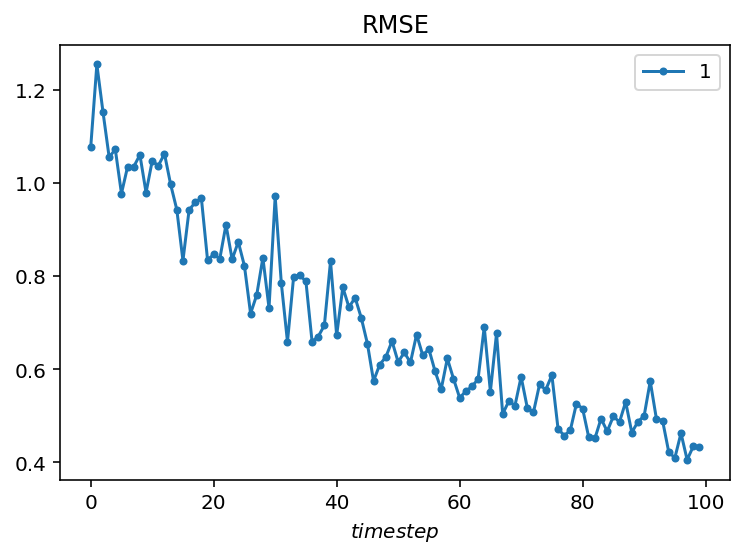

In [91]:
plot_graphs(losses, title="RMSE")

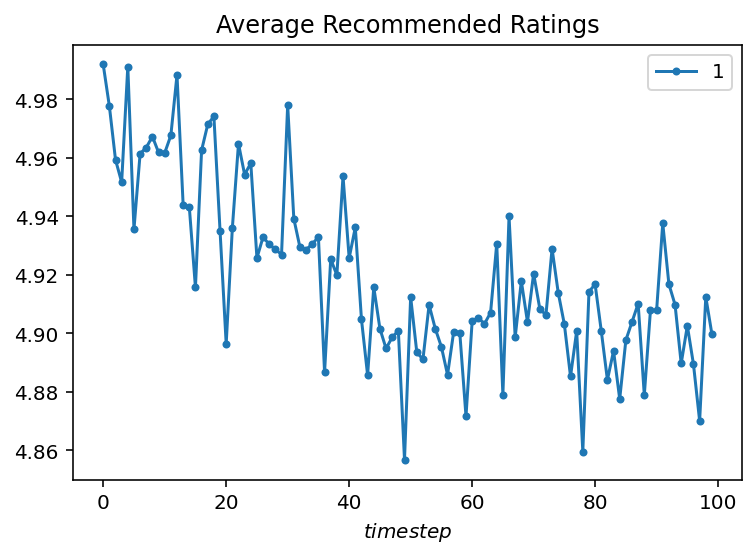

In [92]:
plot_graphs(avg_ratings, title="Average Recommended Ratings")

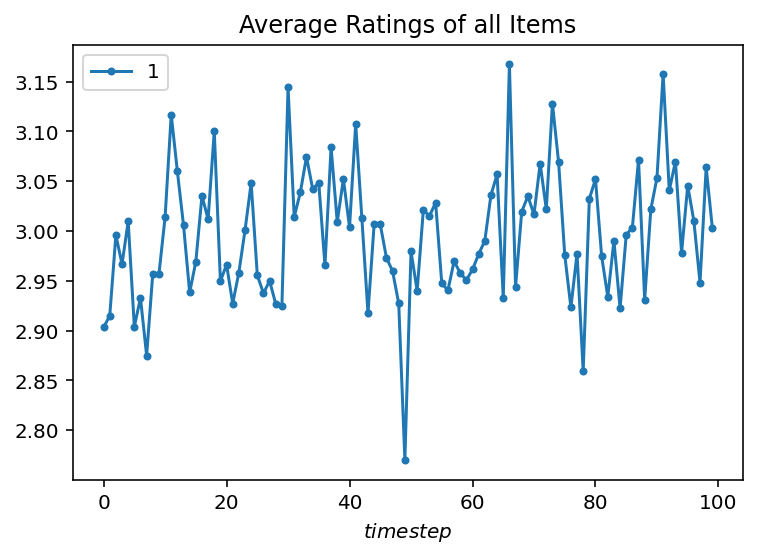

In [93]:
plot_graphs(all_users_avg_rating_of_recommended_items, title="Average Ratings of all Items")

In the workshop, we will explore these results in more detail.

In [96]:
def run_multiple_simulations(callbacks, env):
  recommenders = [
                  LibFM(num_user_features=0, num_item_features=0, num_rating_features=0, max_num_users=NUM_USERS, max_num_items=NUM_ITEMS),
                  RandomRec(rating_range=(1, 5), seed=42),
                  TopPop(),
                  KNNRecommender(),
                  Autorec(num_users=NUM_USERS, num_items=NUM_ITEMS, hidden_neuron=100, train_epoch=100, batch_size=64)
  ]
  for recommender in recommenders:
    metrics = simulation(env, recommender, steps=100, callbacks=callbacks)
    for metric, callback in zip(metrics, callbacks):
      plot_graphs(metric, title=f"{callback.__name__}, {recommender.__class__.__name__}")                  

100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


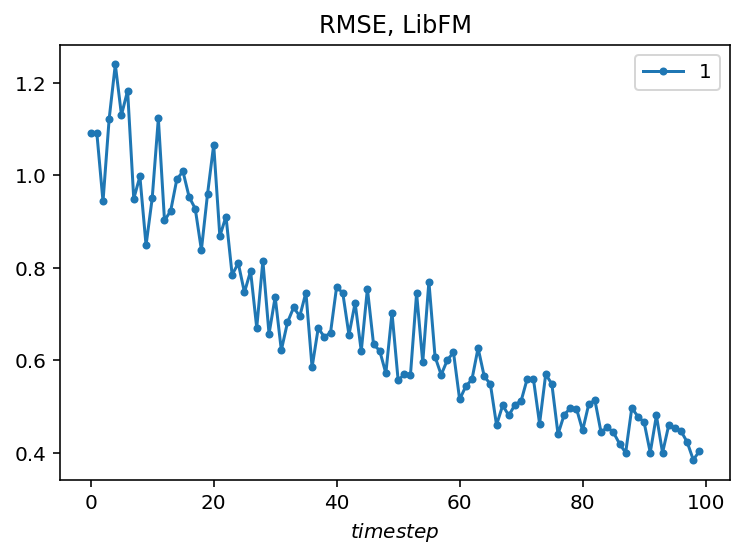

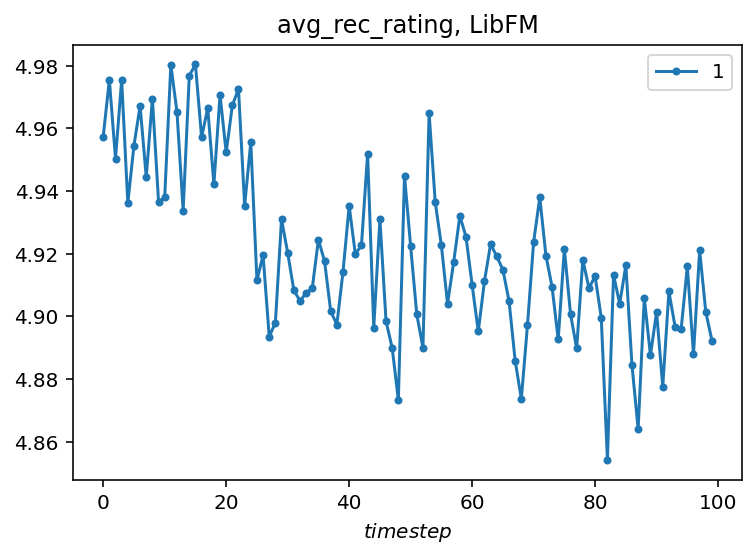

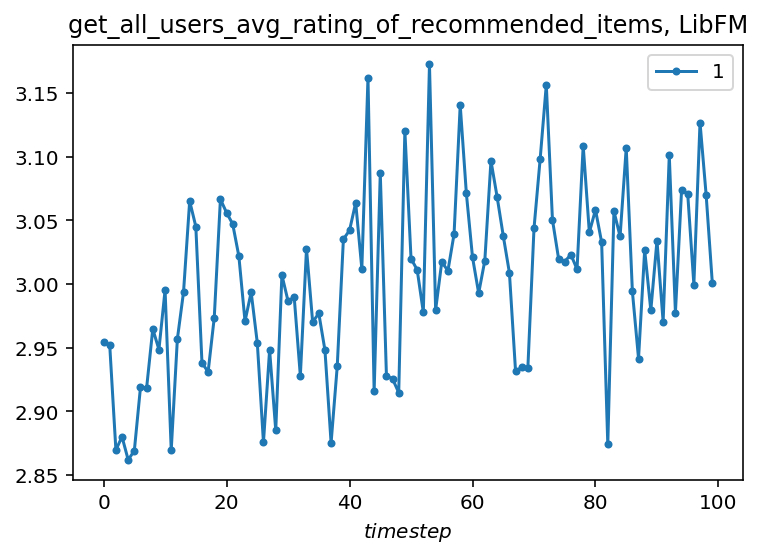

100%|██████████| 100/100 [00:01<00:00, 55.45it/s]


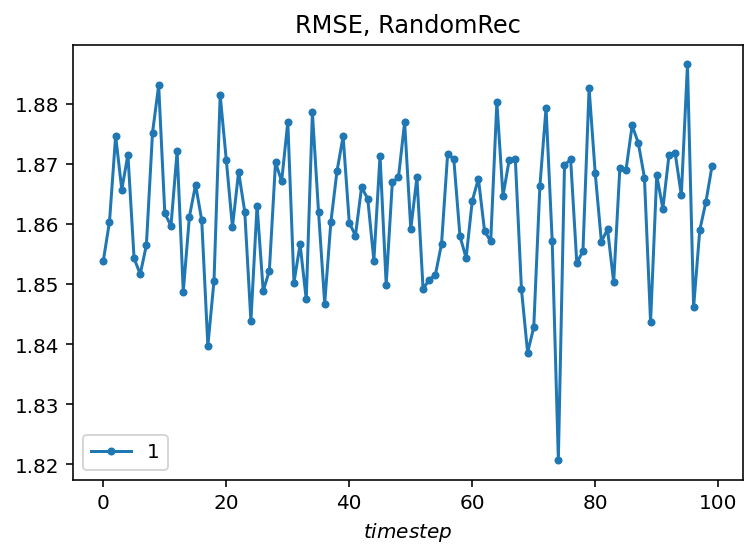

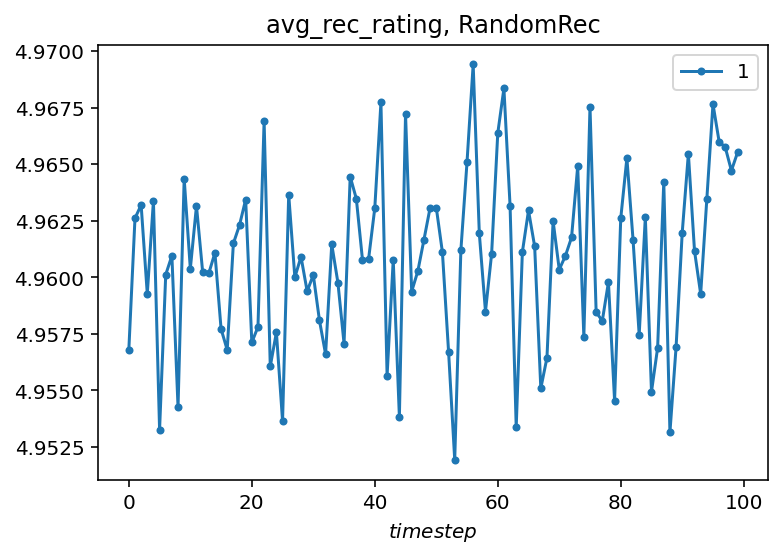

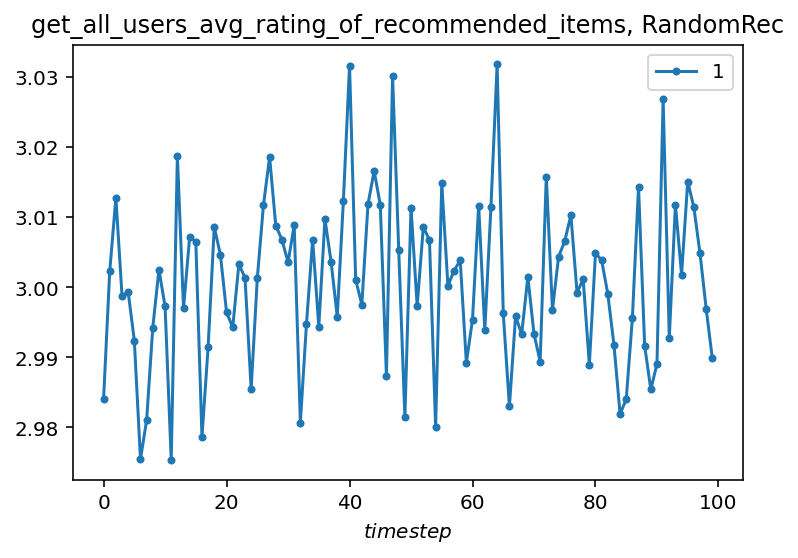

100%|██████████| 100/100 [00:06<00:00, 14.52it/s]


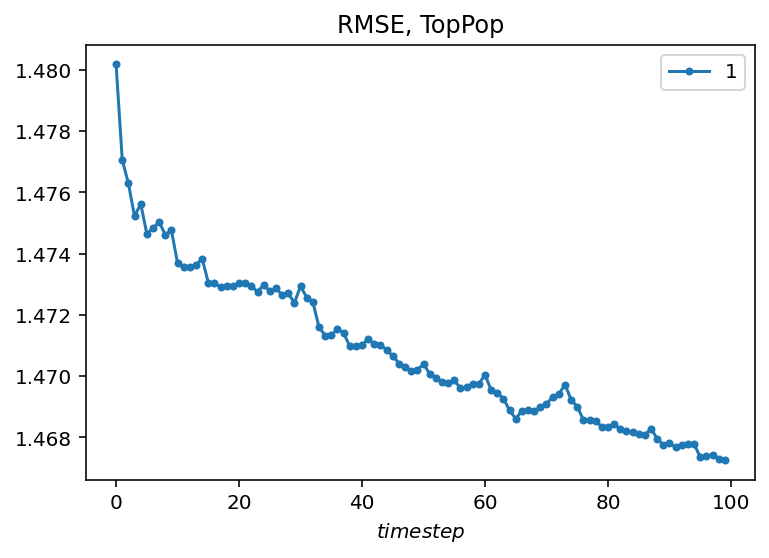

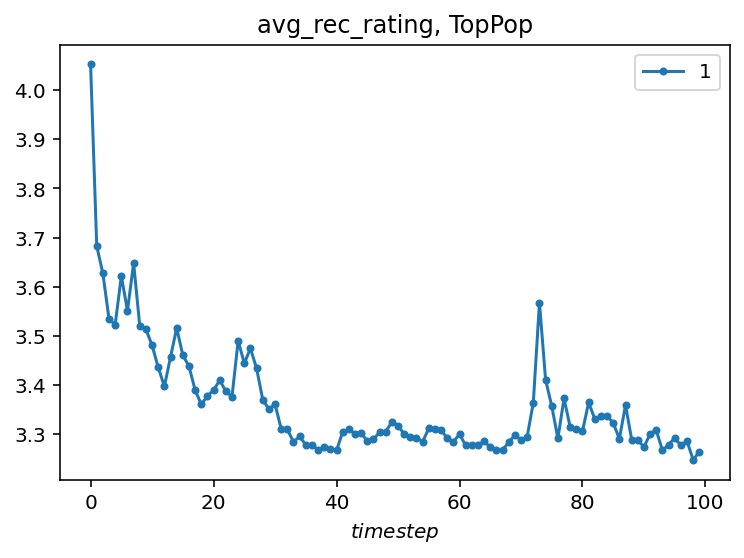

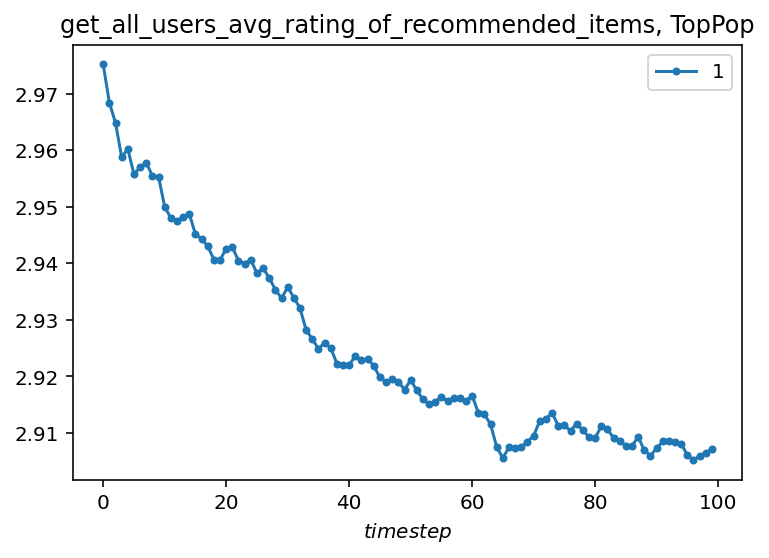

100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


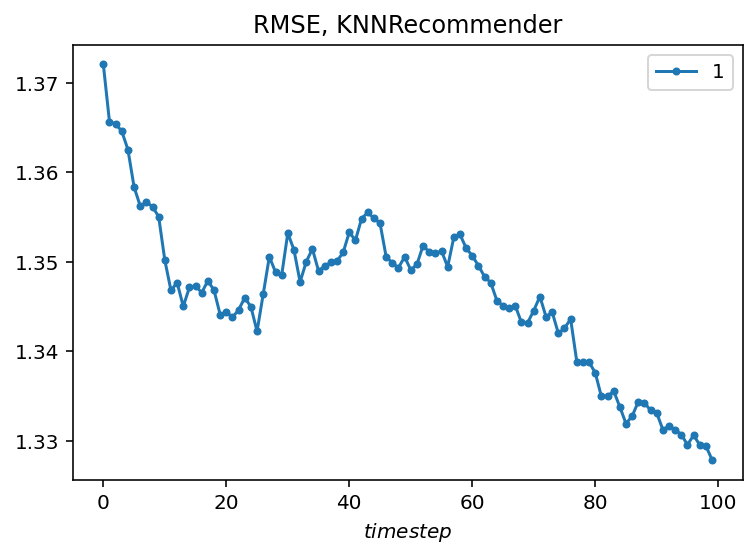

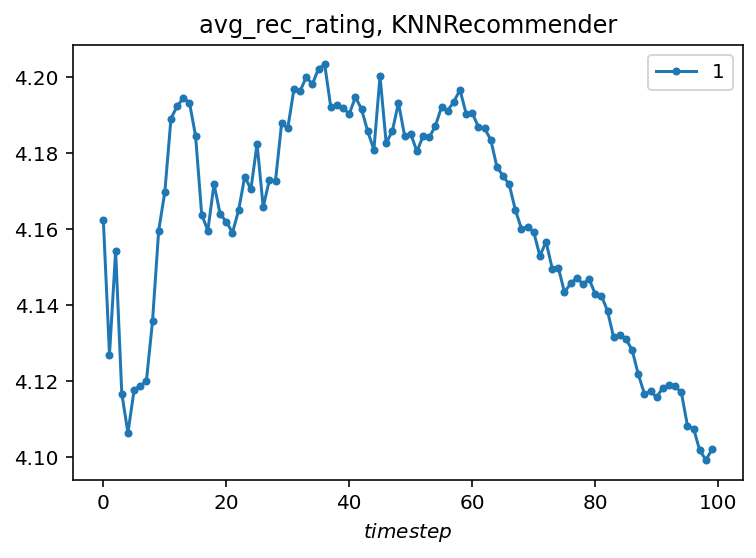

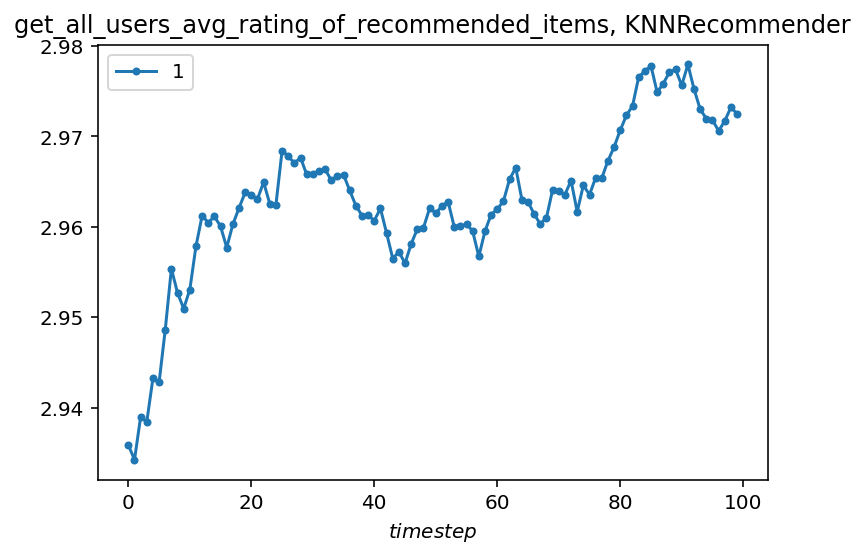

100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


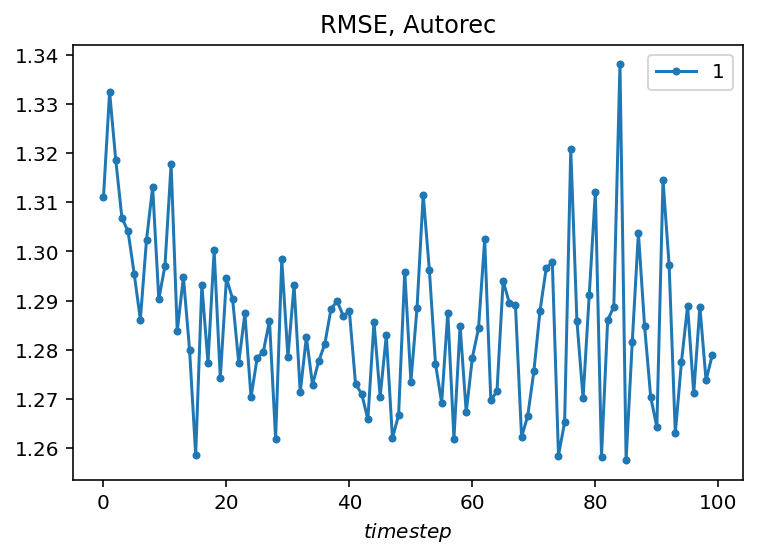

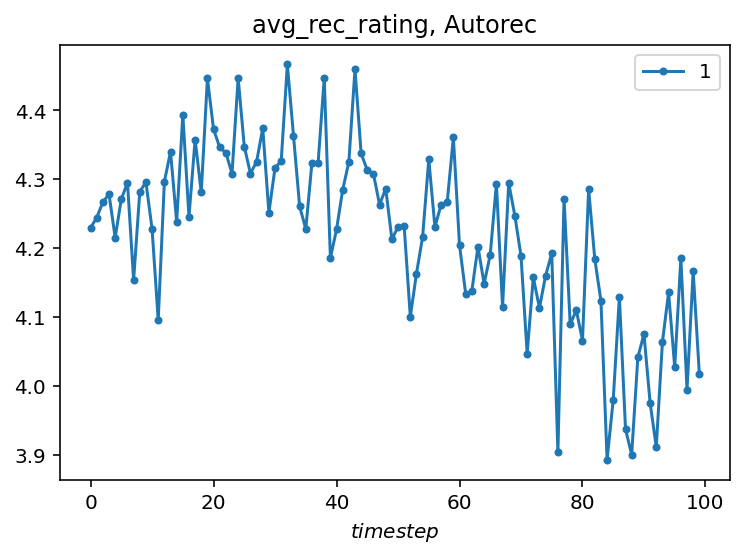

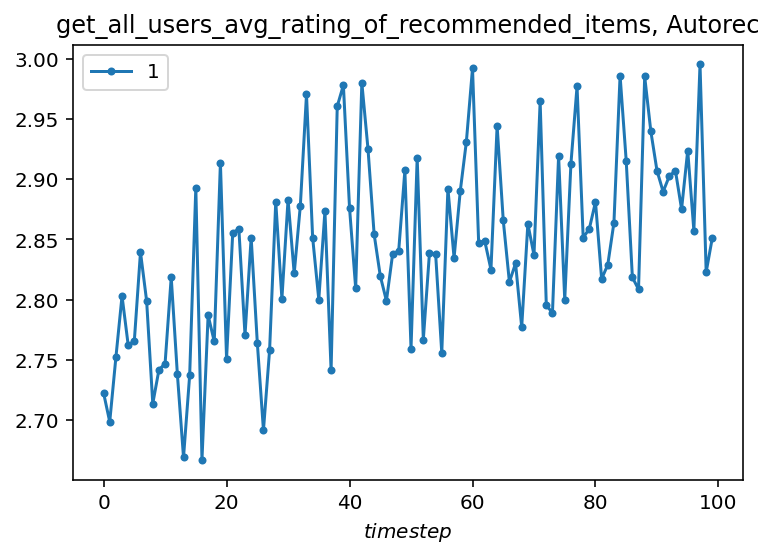

In [97]:
run_multiple_simulations(callbacks, env)

**Show the losses and average ratings graphs you got in question (3) and explain the differences
between them. Which recommendation model best captures this environment? Why do you
think that is?**\
LibFM acheived the best RMSE score and therefore it is the best recommender for this environment. Its std, however, is much higher than KNNRecommender, the 2nd best (RMSE-wise) recommender. We note that the Random Recommender behave as expected: its RMSE & Average Rating remain roughly unchanged during the training and with high variance.